# Timeseries anomaly detection using an Autoencoder

**Author:** [pavithrasv](https://github.com/pavithrasv)<br>
**Date created:** 2020/05/31<br>
**Last modified:** 2020/05/31<br>
**Description:** Detect anomalies in a timeseries using an Autoencoder.

https://github.com/keras-team/keras-io/blob/master/examples/timeseries/ipynb/timeseries_anomaly_detection.ipynb

## Introduction

This script demonstrates how you can use a reconstruction convolutional
autoencoder model to detect anomalies in timeseries data.

## Setup

In [1]:
import numpy as np
import pandas as pd
import keras
from keras import layers, models
from matplotlib import pyplot as plt

2024-08-27 10:21:21.946377: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-27 10:21:24.478604: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from joblib import delayed

In [3]:
import pandas as pd

In [4]:
import random

In [5]:
import tensorflow as tf
from tensorflow.keras.callbacks import Callback

In [6]:
import dask.dataframe as dd
import os
import shutil

In [7]:
batchSize = 1024

## Load the data

We will use the [Numenta Anomaly Benchmark(NAB)](
https://www.kaggle.com/boltzmannbrain/nab) dataset. It provides artificial
timeseries data containing labeled anomalous periods of behavior. Data are
ordered, timestamped, single-valued metrics.

We will use the `art_daily_small_noise.csv` file for training and the
`art_daily_jumpsup.csv` file for testing. The simplicity of this dataset
allows us to demonstrate anomaly detection effectively.

## Build a model

We will build a convolutional reconstruction autoencoder model. The model will
take input of shape `(batch_size, sequence_length, num_features)` and return
output of the same shape. In this case, `sequence_length` is 288 and
`num_features` is 1.

### Get Data  sequences
Create sequences combining `TIME_STEPS` contiguous data values from the
training data.

In [8]:
%%time
TIME_STEPS = 1000
Dims = 3

Folder = '/scratch/1000Sm/'
Folder = '/scratch/1000Input/'
Folder = '/lclscr/1000Inputs/'

CPU times: user 2 μs, sys: 3 μs, total: 5 μs
Wall time: 8.58 μs


In [9]:
%%time 
Olines = [
    os.path.join(Folder,file)
    for file in os.listdir(Folder) if file.endswith('Outs.csv') #and file.startswith('2')
]

CPU times: user 5.18 s, sys: 2.43 s, total: 7.61 s
Wall time: 7.63 s


In [10]:
lines = [sub.replace('Outs', 'Data') for sub in Olines]

with open('FileListAsOf0812-b.txt', 'r') as file:
    # Read all lines into a list
    Alines = [line.rstrip('\n') for line in file]
    
    #file.readlines()
    

lines = []
for line in Alines:
    lines.append(Folder+line[19:])

In [11]:
len(lines)

6754302

In [12]:
random.shuffle(lines)

In [14]:
val_lines = lines[-int(len(lines)/10):]

In [15]:
len(val_lines)

675430

dataset = tf.data.Dataset.list_files(file_list)

In [16]:
def parse_csv(file_path):
    # Read the CSV file
    try:
        df = pd.read_csv(file_path, header=None)
        df.columns = ['rx','ry','rz']
        features = df[['rx','ry','rz']].values.tolist()
    except:
        print(file_path)
        features = np.zeros((1000,3)).tolist()
    
    try:
        label = pd.read_csv(file_path[:-8]+'Outs.csv', header=None)
        label.columns = ['sx']
        labels = np.asarray(label.sx)
    except:
        labels = np.asarray(np.zeros((1000)))
        print(file_path[:-8]+'Outs.csv')
        
    return features, labels

In [17]:
class CustomDataset(tf.keras.utils.Sequence):
    def __init__(self, files, batch_size=batchSize, shuffle=True, **kwargs):
        super().__init__(**kwargs)  # Call the parent class constructor
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.files = files
        self.on_epoch_end()
        self.OneTime = 0
        
    def __len__(self):
        return int(np.floor(len(self.files) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        Feat, Labe = [], []
        
        for idx in indexes:
            f = parse_csv(self.files[idx])
            Feat.append(f[0])
            Labe.append(f[1])

        if self.OneTime == 0:
            print(np.shape(Feat), np.shape(Labe))
            self.OneTime = 1
        
        Feat = tf.convert_to_tensor(Feat, dtype=tf.float32)
        Labe = tf.convert_to_tensor(Labe, dtype=tf.float32)
        return Feat, Labe

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.files))
        if self.shuffle:
            np.random.shuffle(self.indexes)


In [18]:
training_generator = CustomDataset(lines, batch_size=batchSize, shuffle = True)

In [19]:
validation_generator = CustomDataset(val_lines, batch_size=batchSize)

## Train the model

Please note that we are using `x_train` as both the input and the target
since this is a reconstruction model.

model = models.Sequential(
    [
        # Input layer
        layers.Input(shape=(1000, 3)),
        
        # Increased number of filters and added layers
        layers.Conv1D(filters=128, kernel_size=7, padding="same", strides=2, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.Conv1D(filters=64, kernel_size=7, padding="same", strides=2, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.Conv1D(filters=32, kernel_size=7, padding="same", strides=2, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        
        # Dropout layer for regularization
        layers.Dropout(rate=0.3),
        
        # Transpose layers with increased filters
        layers.Conv1DTranspose(filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
        layers.Conv1DTranspose(filters=64, kernel_size=7, padding="same", strides=2, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.Conv1DTranspose(filters=128, kernel_size=7, padding="same", strides=2, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        
        # Dropout layer for regularization
        layers.Dropout(rate=0.3),
        
        # Output layer
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
        
        # Added dense layers with more neurons
        layers.Dense(256, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(1)
    ]
)

In [20]:
models = os.listdir('/scratch/models/')
print(models)

['TAD_08101700_checkpoint_02.h5', 'TAD_08101700_checkpoint_04.h5', 'profiles', 'TAD_0821_checkpoint_a_01.h5', 'TAD_0822_checkpoint_a_01.h5', 'TAD_0821_checkpoint_a_02.h5', 'TAD_0822_checkpoint_a_02.h5', 'TAD_0823_checkpoint_B523_01.keras', 'TAD_0823_checkpoint_B523_02.keras', 'TAD_0823_checkpoint_B523_03.keras', 'TAD_0823_checkpoint_B523_04.keras', 'TAD_0823_checkpoint_B523_05.keras', 'TAD_0823_checkpoint_B523_06.keras', 'TAD_0823_checkpoint_B523_07.keras', 'TAD_0823_checkpoint_B523_08.keras', 'TAD_0823_checkpoint_B523_09.keras', 'TAD_0823_checkpoint_B523_10.keras', 'TAD_0822_checkpoint_a_03.h5']


In [21]:
model = tf.keras.models.load_model('/scratch/models/TAD_0823_checkpoint_B523_10.keras')

2024-08-27 10:25:07.604895: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22287 MB memory:  -> device: 0, name: NVIDIA A30, pci bus id: 0000:19:00.0, compute capability: 8.0


In [ ]:
class CustomModelCheckpoint(Callback):
    def __init__(self, filepath, save_freq):
        super(CustomModelCheckpoint, self).__init__()
        self.filepath = filepath
        self.save_freq = save_freq

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.save_freq == 0:
            self.model.save(self.filepath.format(epoch=epoch + 1), save_format='keras')


In [ ]:
checkpoint_callback = CustomModelCheckpoint(
    filepath='/scratch/models/TAD_0821_checkpoint_ar_{epoch:02d}.h5',
    save_freq=1  
)

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

In [ ]:
history = model.fit(
    x=training_generator,
    epochs=10,
    batch_size=batchSize,
    #validation_split=0.1,
    callbacks=[checkpoint_callback,
        keras.callbacks.EarlyStopping(monitor="loss", patience=5, mode="min")
    ],        
    )

Let's plot training and validation loss to see how the training went.

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
#plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [ ]:
asdfasdfasdf

## Detecting anomalies

We will detect anomalies by determining how well our model can reconstruct
the input data.


1.   Find MAE loss on training samples.
2.   Find max MAE loss value. This is the worst our model has performed trying
to reconstruct a sample. We will make this the `threshold` for anomaly
detection.
3.   If the reconstruction loss for a sample is greater than this `threshold`
value then we can infer that the model is seeing a pattern that it isn't
familiar with. We will label this sample as an `anomaly`.


In [22]:
%%time
# Get train MAE loss.
x_train_pred = model.predict(validation_generator)

(1024, 1000, 3) (1024, 1000)


I0000 00:00:1724768769.257585 2874542 service.cc:145] XLA service 0x14d4ac015f20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724768769.257699 2874542 service.cc:153]   StreamExecutor device (0): NVIDIA A30, Compute Capability 8.0
2024-08-27 10:26:09.376330: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-27 10:26:10.173219: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
I0000 00:00:1724768771.521759 2874627 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1', 64 bytes spill stores, 72 bytes spill loads



  2/659 ━━━━━━━━━━━━━━━━━━━━ 1:30 138ms/step 

I0000 00:00:1724768775.862969 2874542 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


650/659 ━━━━━━━━━━━━━━━━━━━━ 53s 6s/step/lclscr/1000Inputs/230117 recording200038863Outs.csv
659/659 ━━━━━━━━━━━━━━━━━━━━ 3928s 6s/step


In [31]:
y_results = []
for i, file in enumerate(val_lines):
    try:
        label = pd.read_csv(file[:-8]+'Outs.csv', header=None)
        label.columns = ['sx']
        labels = (label.sx)
    except:
        labels = (np.zeros((1000)))
        print(file[:-8]+'Outs.csv')
    y_results.append(labels)

/lclscr/1000Inputs/230117 recording200038863Outs.csv


In [35]:
data_size = len(x_train_pred)

In [39]:
data_size

674816

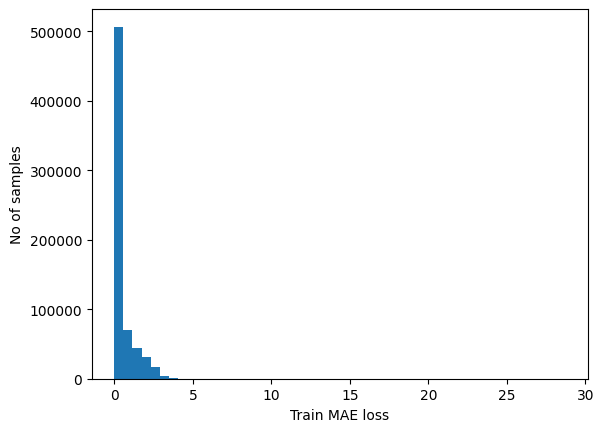

Reconstruction error threshold:  28.73029732583483


In [40]:
train_mae_loss = np.mean(np.abs(x_train_pred - np.asarray(y_results[:data_size]).reshape(data_size,1000,1)), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

### Compare recontruction

Just for fun, let's see how our model has recontructed the first sample.
This is the 288 timesteps from day 1 of our training dataset.

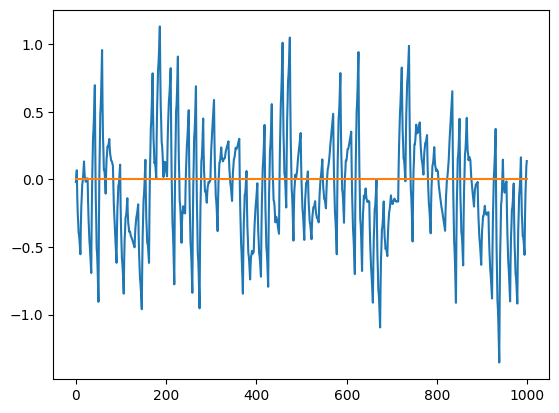

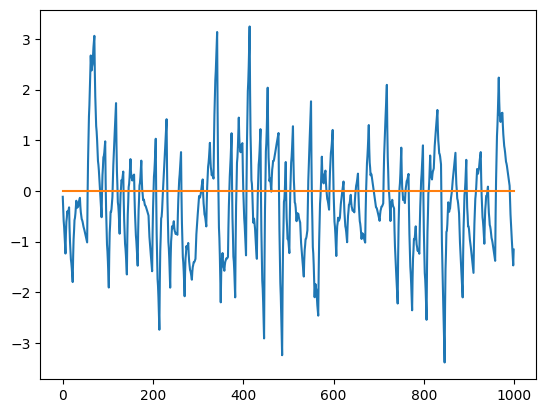

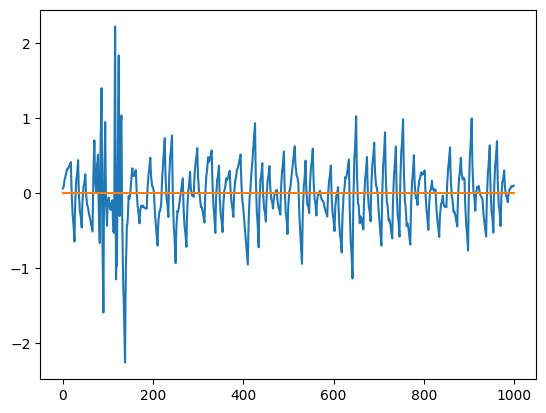

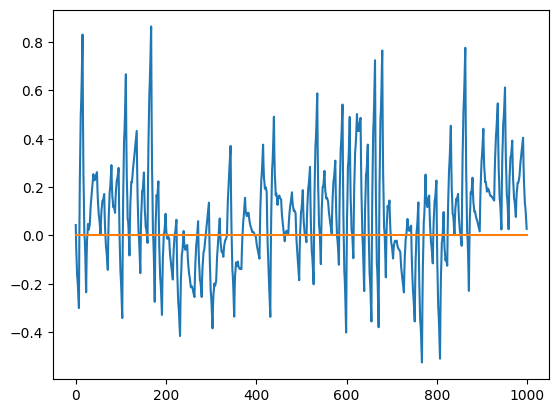

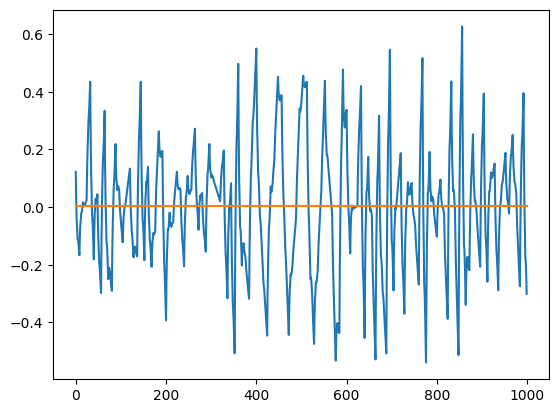

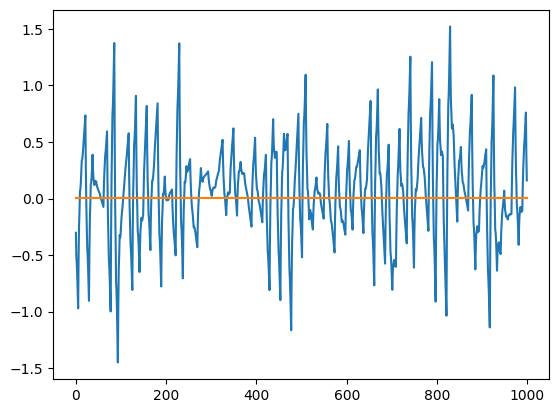

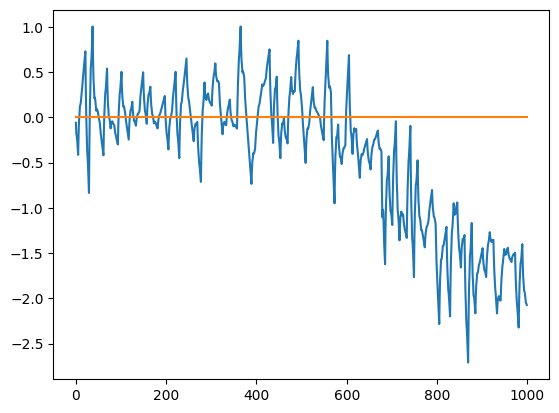

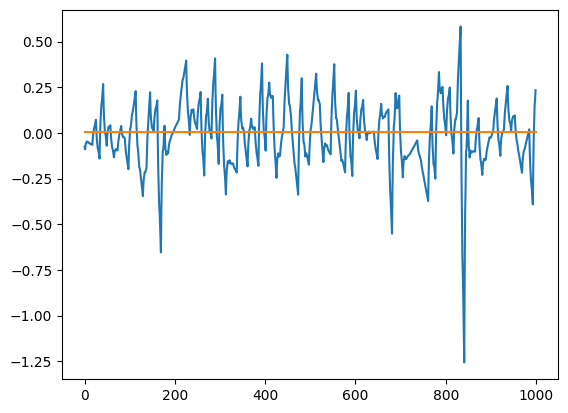

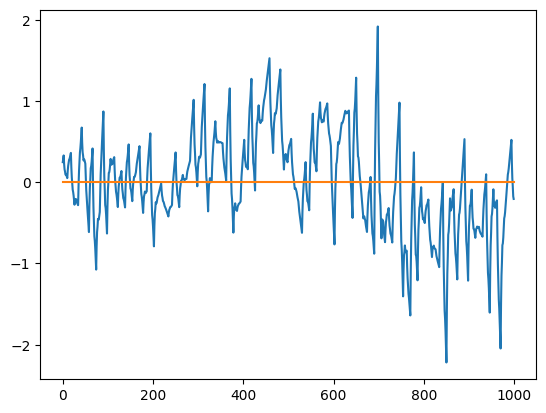

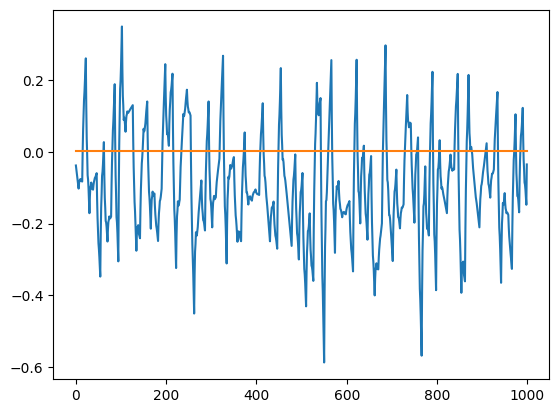

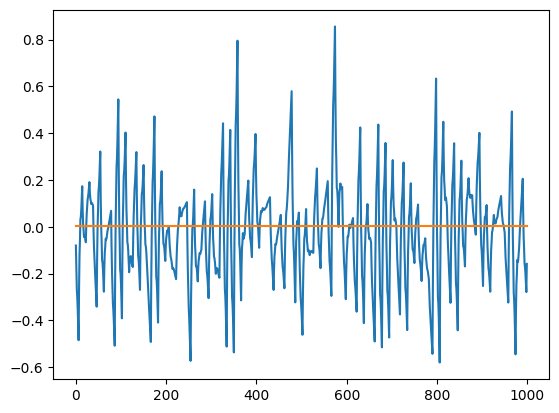

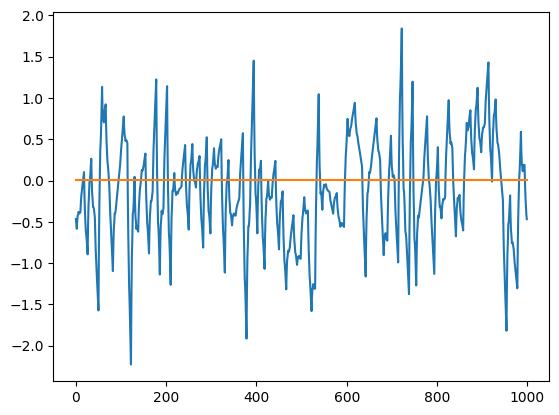

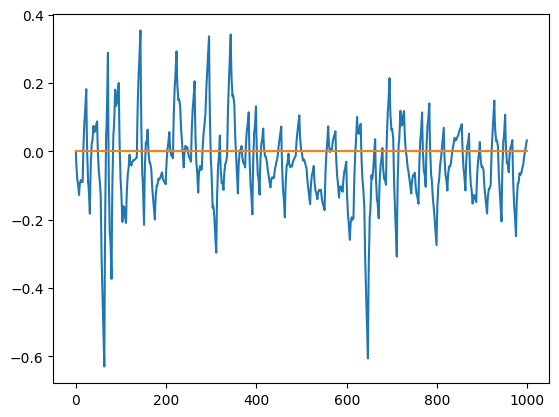

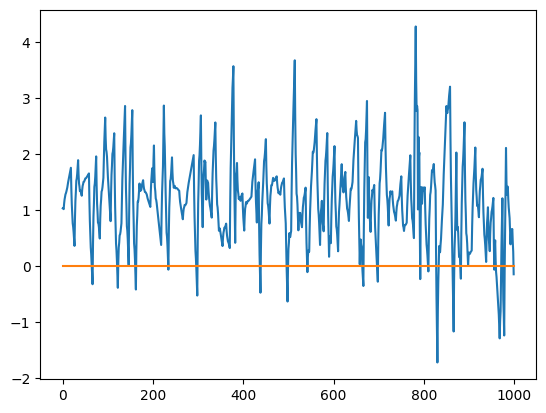

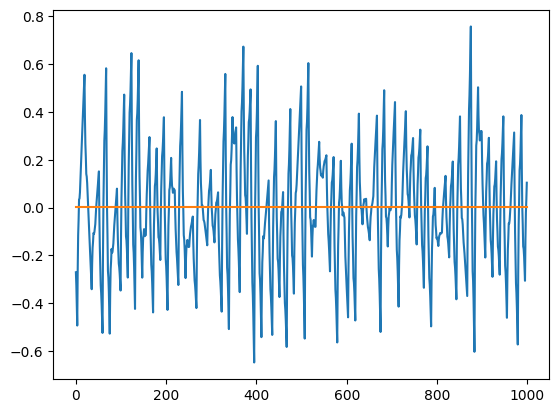

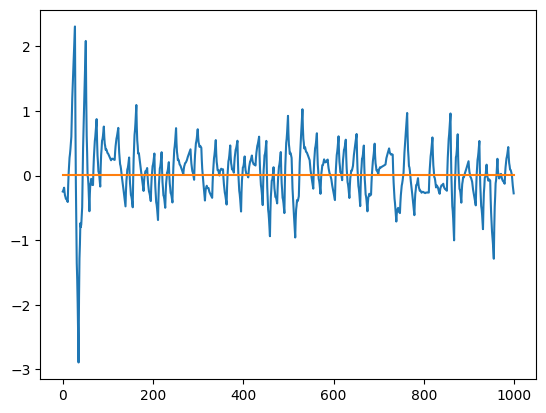

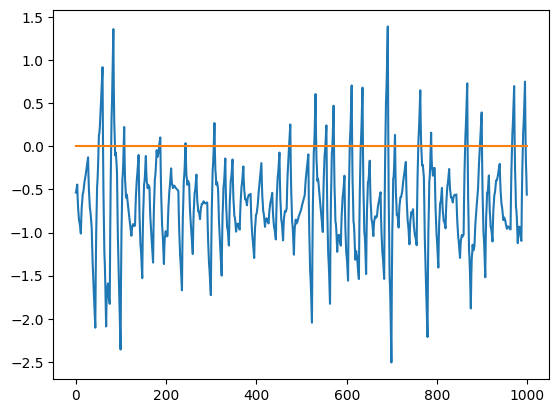

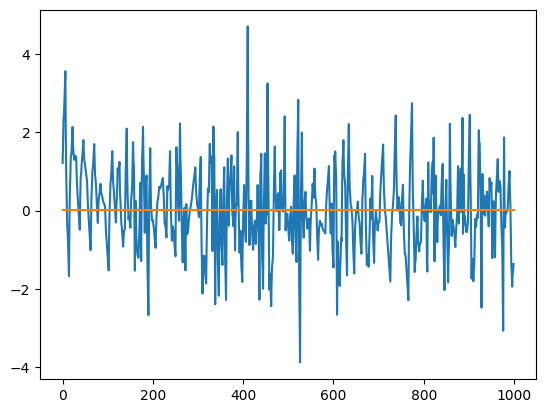

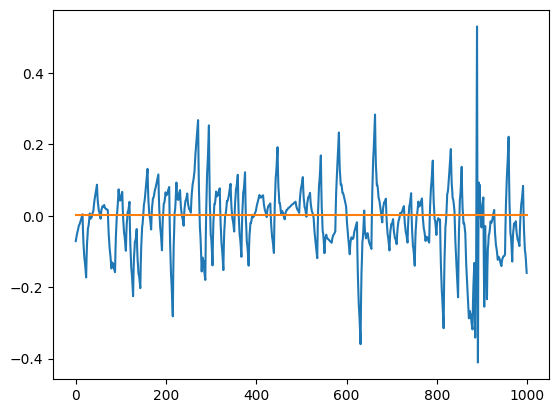

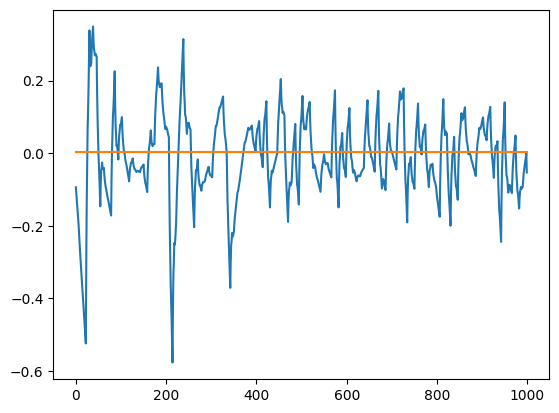

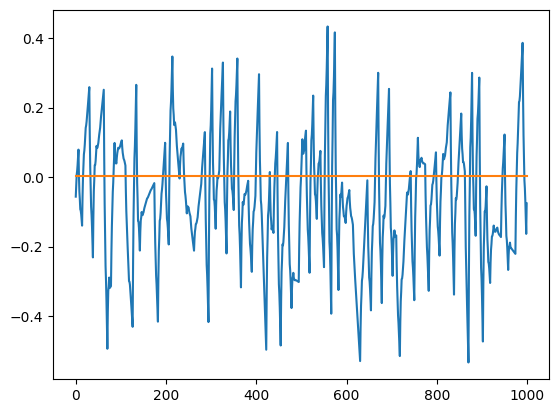

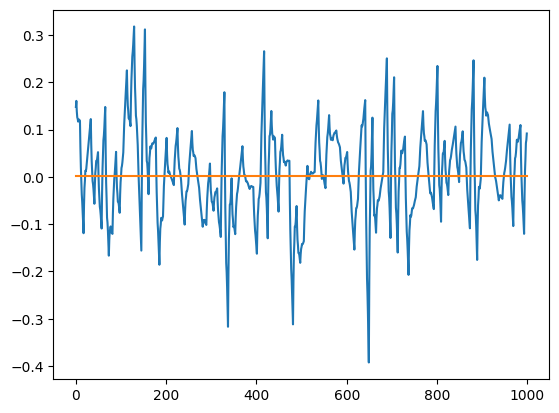

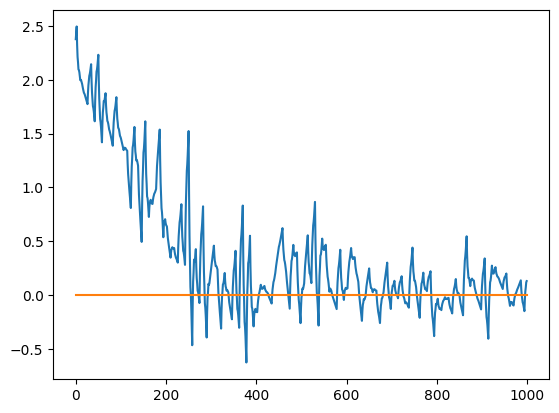

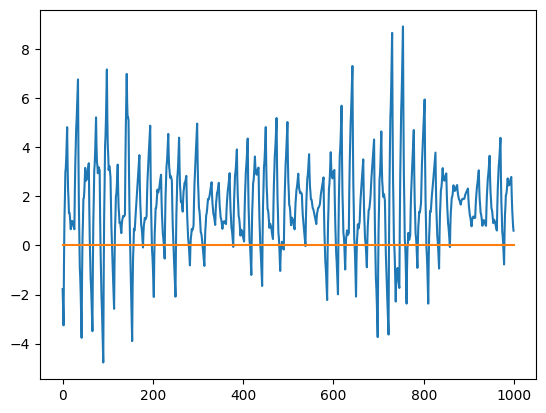

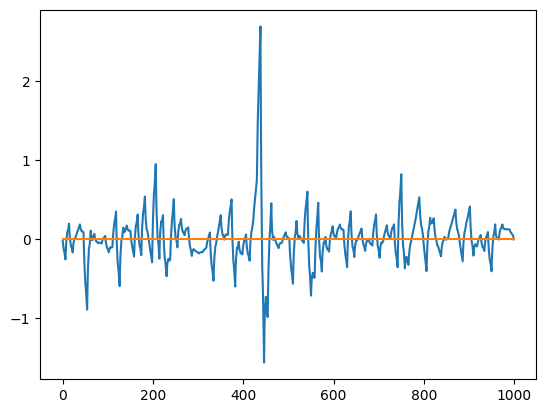

In [42]:
# Checking how the first sequence is learnt
for i in range(25):
    plt.plot(y_results[i*17])
    plt.plot(x_train_pred[i*17])
    plt.show()

### Prepare test data

In [ ]:

df_test_value = (df_daily_jumpsup - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

## Plot anomalies

We now know the samples of the data which are anomalies. With this, we will
find the corresponding `timestamps` from the original test data. We will be
using the following method to do that:

Let's say time_steps = 3 and we have 10 training values. Our `x_train` will
look like this:

- 0, 1, 2
- 1, 2, 3
- 2, 3, 4
- 3, 4, 5
- 4, 5, 6
- 5, 6, 7
- 6, 7, 8
- 7, 8, 9

All except the initial and the final time_steps-1 data values, will appear in
`time_steps` number of samples. So, if we know that the samples
[(3, 4, 5), (4, 5, 6), (5, 6, 7)] are anomalies, we can say that the data point
5 is an anomaly.

In [ ]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

Let's overlay the anomalies on the original test data plot.

In [ ]:
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()